In [ ]:
import os
import glob
import random
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from tqdm import tqdm
from types import SimpleNamespace
import albumentations as A
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import timm
import pydicom

In [ ]:
def convert_to_8bit(x):
    lower, upper = np.percentile(x, (1, 99))
    x = np.clip(x, lower, upper)
    x = x - np.min(x)
    x = x / np.max(x)
    return (x * 255).astype("uint8")

def load_dicom_stack(dicom_folder, plane, reverse_sort=False):
    dicom_files = glob.glob(os.path.join(dicom_folder, "*.dcm"))
    dicoms = [pydicom.dcmread(f) for f in dicom_files]

    # Select the corresponding plane axis based on the given slice, 0: sagittal, 1: coronal, 2: axial
    plane = {"sagittal": 0, "coronal": 1, "axial": 2}[plane.lower()]
    positions = np.asarray([float(d.ImagePositionPatient[plane]) for d in dicoms]) ## Extracting positions
    idx = np.argsort(-positions if reverse_sort else positions)
    ipp = np.asarray([d.ImagePositionPatient for d in dicoms]).astype("float")[idx]
    array = np.stack([d.pixel_array.astype("float32") for d in dicoms])
    array = array[idx]
    return {"array": convert_to_8bit(array), "positions": ipp, "pixel_spacing": np.asarray(dicoms[0].PixelSpacing).astype("float")}


In [ ]:
# Image adjustment transformation using the Albumentations library
resize_transform = A.Compose([
    A.LongestMaxSize(max_size=256, interpolation=cv2.INTER_CUBIC, always_apply=True),
    A.PadIfNeeded(min_height=256, min_width=256, border_mode=cv2.BORDER_CONSTANT, value=(0, 0, 0), always_apply=True),  ## Black border
])

def angle_of_line(x1, y1, x2, y2):
    """
    Calculate the angle (in degrees) of a line between two points.
    """
    return math.degrees(math.atan2(-(y2 - y1), x2 - x1))
def plot_img(img, coords_temp):
    """
    Plot key points on an image.
    """
    fig, ax = plt.subplots()
    ax.imshow(img, cmap='gray')
    h, w = img.shape
    p = coords_temp.groupby("level").apply(lambda g: list(zip(g['relative_x'], g['relative_y'])), include_groups=False).reset_index(drop=False, name="vals")
    for _, row in p.iterrows():
        level = row['level']
        x = [coord[0] * w for coord in row["vals"]]
        y = [coord[1] * h for coord in row["vals"]]
        ax.plot(x, y, marker='o')
    ax.axis('off')
    plt.show()
def plot_5_crops(img, coords_temp):
    """
    Crop the image based on key point information and display five cropped results.
    """
    fig = plt.figure(figsize=(10, 10))
    gs = gridspec.GridSpec(1, 5, width_ratios=[1]*5)
    p = coords_temp.groupby("level").apply(
        lambda g: list(zip(g['relative_x'], g['relative_y'])),
        include_groups=False
    ).reset_index(drop=False, name="vals")
    for idx, (_, row) in enumerate(p.iterrows()):
        img_copy = img.copy()
        h, w = img.shape
        level = row['level']
        vals = sorted(row["vals"], key=lambda x: x[0])
        a, b = vals
        a = (a[0] * w, a[1] * h)
        b = (b[0] * w, b[1] * h)
        rotate_angle = angle_of_line(a[0], a[1], b[0], b[1])
        transform = A.Compose([
            A.Rotate(limit=(-rotate_angle, -rotate_angle), p=1.0),
        ], keypoint_params=A.KeypointParams(format='xy', remove_invisible=False))

        t = transform(image=img_copy, keypoints=[a, b])
        img_copy = t["image"]
        a, b = t["keypoints"]
        img_copy = crop_between_keypoints(img_copy, a, b)
        img_copy = resize_transform(image=img_copy)["image"]
        ax = plt.subplot(gs[idx])
        ax.imshow(img_copy, cmap='gray')
        ax.set_title(level)
        ax.axis('off')
    plt.show()
def crop_between_keypoints(img, keypoint1, keypoint2):

    """

    Crop a specific region of the image based on the positions of two key points.

    """

    h, w = img.shape

    x1, y1 = int(keypoint1[0]), int(keypoint1[1])

    x2, y2 = int(keypoint2[0]), int(keypoint2[1])



    left = int(min(x1, x2))

    right = int(max(x1, x2))

    top = int(min(y1, y2) - (h * 0.1))

    bottom = int(max(y1, y2) + (h * 0.1))



    top = max(top, 0)

    bottom = min(bottom, h)

    left = max(left, 0)

    right = min(right, w)



    return img[top:bottom, left:right]


In [7]:
# Path to DICOM image folder

image_dir = "/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images"

In [ ]:
dfd = pd.read_csv("/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_series_descriptions.csv")
# Filter out data with series description as "Sagittal T2/STIR"
dfd = dfd[dfd.series_description == "Sagittal T2/STIR"]
dfd = dfd[dfd['study_id'] == 100206310]
dfd

,study_id,series_id,series_description
145,100206310,1792451510,Sagittal T2/STIR


In [ ]:
coords = pd.read_csv("/kaggle/input/lumbar-coordinate-pretraining-dataset/coords_rsna_improved.csv")
coords.head()

#The characteristic is that each bone is marked with two points to determine the specific coordinate information between a joint.

,Unnamed: 0,series_id,relative_x,relative_y,condition,side,instance_number,study_id,level
0,0,10996,0.521148,0.325282,Left Neural Foraminal Narrowing,L,13,3996069892,L1/L2
1,1,10996,0.516856,0.319701,Right Neural Foraminal Narrowing,R,6,3996069892,L1/L2
2,2,10996,0.493773,0.400966,Left Neural Foraminal Narrowing,L,12,3996069892,L2/L3
3,3,10996,0.504032,0.385531,Right Neural Foraminal Narrowing,R,6,3996069892,L2/L3
4,4,10996,0.487331,0.475040,Left Neural Foraminal Narrowing,L,12,3996069892,L3/L4


In [21]:
coords.shape

(58735, 9)

In [22]:
# Sort the coordinate data and reset the index

# Change the data order to slice/bone/side (left or right)

coords = coords.sort_values(["series_id", "level", "side"]).reset_index(drop=True)

# Select the columns we need



coords = coords[["series_id", "level", "side", "relative_x", "relative_y"]]

coords.head()


,series_id,level,side,relative_x,relative_y
0,10996,L1/L2,L,0.521148,0.325282
1,10996,L1/L2,R,0.516856,0.319701
2,10996,L2/L3,L,0.493773,0.400966
3,10996,L2/L3,R,0.504032,0.385531
4,10996,L3/L4,L,0.487331,0.475040


In [24]:
# Testing with a single sample

dicom_files = glob.glob(os.path.join("/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/100206310/1792451510", "*.dcm"))

dicom_files

['/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/100206310/1792451510/12.dcm',
 '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/100206310/1792451510/18.dcm',
 '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/100206310/1792451510/9.dcm',
 '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/100206310/1792451510/14.dcm',
 '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/100206310/1792451510/11.dcm',
 '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/100206310/1792451510/10.dcm',
 '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/100206310/1792451510/17.dcm',
 '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/100206310/1792451510/1.dcm',
 '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/100206310/1792451510/15.dcm',
 '/kaggle/in

In [25]:
# int(len(dicom_files)/2)

In [26]:
dicoms = [pydicom.dcmread(f) for f in dicom_files]

dicoms[0]

Dataset.file_meta -------------------------------
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Enhanced MR Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 100206310.1.12
(0002, 0010) Transfer Syntax UID                 UI: RLE Lossless
(0002, 0012) Implementation Class UID            UI: 1.2.40.0.13.1.1.1
(0002, 0013) Implementation Version Name         SH: 'PYDICOM 2.4.2'
-------------------------------------------------
(0008, 0018) SOP Instance UID                    UI: 100206310.1.12
(0008, 0023) Content Date                        DA: '20240503'
(0008, 0033) Content Time                        TM: '223744.084561'
(0008, 103e) Series Description                  LO: 'T2'
(0010, 0020) Patient ID                          LO: '100206310'
(0018, 0050) Slice Thickness                     DS: '4.0'
(0018, 0088) Spacing Between Slices              DS: '4.48'
(0018, 5100) Patient Position          

In [27]:
plane = "sagittal"

# Select the corresponding plane axis based on the given plane, 0: sagittal, 1: coronal, 2: axial

plane = {"sagittal": 0, "coronal": 1, "axial": 2}[plane.lower()]

plane

0

In [28]:
# Extract the position of each DICOM image on the selected plane, here refers to the position on the X plane (it should be read in a bunch, not necessarily in order)

positions = np.asarray([float(d.ImagePositionPatient[plane]) for d in dicoms])

positions

array([ 17.41016586,  44.26772697,   3.98138483,  26.36268623,
        12.93390472,   8.45764454,  39.79146583, -31.82869713,
        30.83894737, -27.35243599,  -0.49487542,  -4.97113554,
       -13.92365544, -18.39991562,  -9.44739525,  35.31520469,
       -22.87617676,  21.88642509])

In [29]:
# If reverse_sort=False, the increased array index will be from right to left, and from tail to head,

# Therefore, we set reverse_sort to True during the cross section, so that the increased array index is in the head-to-tail direction (head side -> tail side)

reverse_sort = 'False'

idx = np.argsort(-positions if reverse_sort else positions)

idx

array([ 1,  6, 15,  8,  3, 17,  0,  4,  5,  2, 10, 11, 14, 12, 13, 16,  9,
        7])

In [30]:
# Get the patient position array of the image and arrange it according to the sorted index

ipp = np.asarray([d.ImagePositionPatient for d in dicoms]).astype("float")[idx]

ipp

array([[  44.26772697,  -59.28254455, -397.68256423],
       [  39.79146583,  -59.13046783, -397.5807409 ],
       [  35.31520469,  -58.97839111, -397.47891751],
       [  30.83894737,  -58.82631439, -397.37709418],
       [  26.36268623,  -58.67424148, -397.27527085],
       [  21.88642509,  -58.52216476, -397.17344752],
       [  17.41016586,  -58.37008804, -397.07162418],
       [  12.93390472,  -58.21801132, -396.96980085],
       [   8.45764454,  -58.06593459, -396.8679775 ],
       [   3.98138483,  -57.91385787, -396.76615417],
       [  -0.49487542,  -57.76178115, -396.66433083],
       [  -4.97113554,  -57.60970443, -396.56250748],
       [  -9.44739525,  -57.45762771, -396.46068415],
       [ -13.92365544,  -57.30555099, -396.35886082],
       [ -18.39991562,  -57.15347427, -396.25703749],
       [ -22.87617676,  -57.00140136, -396.15521416],
       [ -27.35243599,  -56.84932464, -396.05339083],
       [ -31.82869713,  -56.69724792, -395.95156744]])

In [31]:
# Get the pixel data of the DICOM image and convert it to float32 type, then arrange it by the sorted index

array = np.stack([d.pixel_array.astype("float32") for d in dicoms])

array = array[idx]

# Convert the image to 8 bits and return the image array, position array and pixel spacing information

print({"array": convert_to_8bit(array), "positions": ipp, "pixel_spacing": np.asarray(dicoms[0].PixelSpacing).astype("float")})

{'array': array([[[ 3,  4,  3, ...,  0,  0,  0],
        [ 5, 11, 12, ...,  0,  0,  0],
        [ 5, 15, 14, ...,  0,  0,  0],
        ...,
        [ 4, 18, 18, ...,  0,  0,  0],
        [ 4,  9, 11, ...,  0,  0,  0],
        [ 4,  3,  2, ...,  0,  0,  0]],

       [[ 4,  3,  2, ...,  0,  0,  0],
        [ 3, 11, 15, ...,  0,  0,  0],
        [ 4, 12, 10, ...,  0,  0,  0],
        ...,
        [ 4, 12, 15, ...,  0,  0,  0],
        [ 3, 11, 14, ...,  0,  0,  0],
        [ 3,  3,  1, ...,  0,  0,  0]],

       [[ 3,  3,  2, ...,  0,  0,  0],
        [ 3,  6, 11, ...,  0,  0,  0],
        [ 4,  8, 11, ...,  0,  0,  0],
        ...,
        [ 5, 20, 12, ...,  0,  0,  0],
        [ 7,  9, 14, ...,  0,  0,  0],
        [ 4,  3,  2, ...,  0,  0,  0]],

       ...,

       [[ 3,  2,  1, ...,  0,  0,  0],
        [ 3, 15, 15, ...,  0,  0,  0],
        [ 9, 14, 12, ...,  0,  0,  0],
        ...,
        [ 3, 25, 21, ...,  0,  0,  0],
        [ 3, 30, 18, ...,  0,  0,  0],
        [ 9,  7,  0, .

-------------------------  STUDY_ID: 100206310, SERIES_ID: 1792451510  -------------------------
Keypoint information for this slice:         series_id  level side  relative_x  relative_y
24393  1792451510  L1/L2    L    0.351562    0.292969
24394  1792451510  L1/L2    R    0.536381    0.327962
24395  1792451510  L2/L3    L    0.296875    0.421875
24396  1792451510  L2/L3    R    0.511229    0.439460
24397  1792451510  L3/L4    L    0.273438    0.578125
24398  1792451510  L3/L4    R    0.504042    0.557927
24399  1792451510  L4/L5    L    0.296875    0.734375
24400  1792451510  L4/L5    R    0.516619    0.685105
24401  1792451510  L5/S1    L    0.371094    0.878906
24402  1792451510  L5/S1    R    0.552551    0.780923


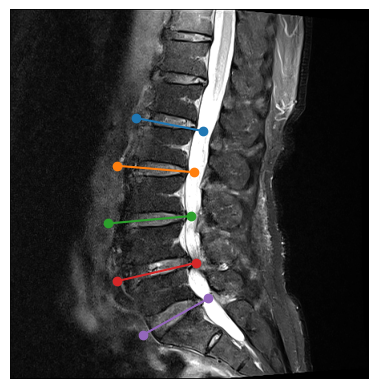

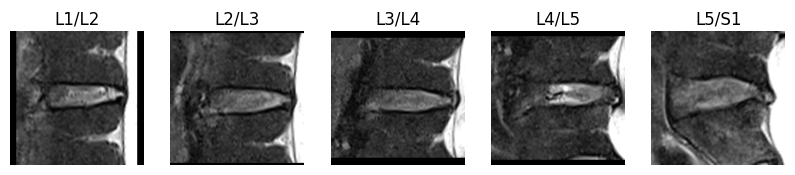

In [32]:
# Iterate through the samples and plot the images and cropped results

for idx, row in dfd.iterrows():

    try:

        # Output the current study_id and series_id being processed

        print("-" * 25, " STUDY_ID: {}, SERIES_ID: {} ".format(row.study_id, row.series_id), "-" * 25)



        # Load the DICOM images corresponding to the specified study_id and series_id (best quality channel direction)

        dicom_path = os.path.join(image_dir, str(row.study_id), str(row.series_id))

        dicom_files = glob.glob(os.path.join(dicom_path, "*.dcm"))

        if not dicom_files:

            print(f"No DICOM files found in path: {dicom_path}")

            continue  # Skip to the next iteration if no files are found

        sag_t2 = load_dicom_stack(os.path.join(image_dir, str(row.study_id), str(row.series_id)), plane="sagittal")

        # Retrieve image data and corresponding key point coordinates

        img = sag_t2["array"][len(sag_t2["array"])//2]  # Use the middle layer image for display (i.e., only the central channel is selected for display)

        coords_temp = coords[coords["series_id"] == row.series_id].copy()



        print('Keypoint information for this slice:', coords_temp)

        # Plot the image and its keypoints

        plot_img(img, coords_temp)

        # Plot five cropped regions of the image

        try:

            plot_5_crops(img, coords_temp)

        except ValueError as e:

            print(f"Error in plot_5_crops: {e}")

            print("Keypoint data causing issue:", coords_temp)





    except Exception as e:

        # If an exception occurs when processing a sample, output the exception message and continue with the next sample

        print(e)

        pass


## Coordinate Dataset training

In [46]:
# Configure model training parameters

cfg = SimpleNamespace(

    img_dir="/kaggle/input/lumbar-coordinate-pretraining-dataset/data",  # Path to the dataset

    device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),  # Set device to GPU (if available), otherwise use CPU

    n_frames=3,  # Number of frames to process, possibly representing time steps of video data

    epochs=5,  # Number of training epochs

    lr=0.0005,  # Learning rate, controls the step size for weight updates

    batch_size=16,  # Batch size, number of samples processed in each training step

    backbone="resnet18",  # The backbone model, using ResNet18 here

)




In [47]:
df = pd.read_csv("/kaggle/input/lumbar-coordinate-pretraining-dataset/coords_pretrain.csv")  # Load data from CSV file

df.head()

,filename,source,x,y,level,relative_x,relative_y
0,1_t2.jpg,spider,139,175,L5/S1,0.542969,0.683594
1,1_t2.jpg,spider,133,157,L4/L5,0.519531,0.613281
2,1_t2.jpg,spider,132,131,L3/L4,0.515625,0.511719
3,1_t2.jpg,spider,131,102,L2/L3,0.511719,0.398438
4,1_t2.jpg,spider,134,84,L1/L2,0.523438,0.328125


In [48]:
df['source'].unique()

array(['spider', 'lsd', 'tseg', 'osf'], dtype=object)

In [49]:
df = df.sort_values(["source", "filename", "level"]).reset_index(drop=True)  # Sort by "source", "filename" and "level" columns and reset index

In [50]:
df["filename"] = df["filename"].str.replace(".jpg", ".npy")  # Replace the ".jpg" extension in the file name with ".npy"

df["series_id"] = df["source"] + "_" + df["filename"].str.split(".").str[0]  # Create a new "series_id" column, combining "source" and the filename part with the extension removed



df.head(6)

,filename,source,x,y,level,relative_x,relative_y,series_id
0,0001.npy,lsd,101,77,L1/L2,0.394531,0.300781,lsd_0001
1,0001.npy,lsd,92,106,L2/L3,0.359375,0.414062,lsd_0001
2,0001.npy,lsd,89,138,L3/L4,0.347656,0.539062,lsd_0001
3,0001.npy,lsd,88,166,L4/L5,0.343750,0.648438,lsd_0001
4,0001.npy,lsd,91,189,L5/S1,0.355469,0.738281,lsd_0001
5,0002.npy,lsd,113,68,L1/L2,0.441406,0.265625,lsd_0002


In [51]:
# Print number of images from each source

print("----- Number of images per source -----")

display((df.source.value_counts() / 5).astype(int).reset_index())  # Count the number of images from each source and divide by 5 before displaying


----- Number of images per source -----


,source,count
0,lsd,504
1,tseg,375
2,spider,209
3,osf,33


In [52]:
df.head()

,filename,source,x,y,level,relative_x,relative_y,series_id
0,0001.npy,lsd,101,77,L1/L2,0.394531,0.300781,lsd_0001
1,0001.npy,lsd,92,106,L2/L3,0.359375,0.414062,lsd_0001
2,0001.npy,lsd,89,138,L3/L4,0.347656,0.539062,lsd_0001
3,0001.npy,lsd,88,166,L4/L5,0.343750,0.648438,lsd_0001
4,0001.npy,lsd,91,189,L5/S1,0.355469,0.738281,lsd_0001


## Dataset



Here we define the torch dataset that will be used during training.

In [53]:
class PreTrainDataset(torch.utils.data.Dataset):

    def __init__(self, df, cfg):

        self.cfg = cfg  # Configuration parameters

        self.records = self.load_coords(df)  # Load coordinate data



    def load_coords(self, df):

        # Convert data to dictionary

        d = df.groupby("series_id")[["relative_x", "relative_y"]].apply(lambda x: list(x.itertuples(index=False, name=None)))

        records = {}

        for i, (k, v) in enumerate(d.items()):

            records[i] = {"series_id": k, "label": np.array(v).flatten()}  # Flatten and store coordinate data

            assert len(v) == 5  # Ensure each series has 5 data points

        return records



    def pad_image(self, img):

        n = img.shape[-1]  # Get the last dimension of the image (number of frames)

        if n >= self.cfg.n_frames:

            start_idx = (n - self.cfg.n_frames) // 2  # Calculate the starting frame index

            return img[:, :, start_idx:start_idx + self.cfg.n_frames]  # Crop to the desired number of frames

        else:

            pad_left = (self.cfg.n_frames - n) // 2  # Calculate the amount of padding on the left

            pad_right = self.cfg.n_frames - n - pad_left  # Calculate the amount of padding on the right

            return np.pad(img, ((0, 0), (0, 0), (pad_left, pad_right)), 'constant', constant_values=0)  # Pad the image



    def load_img(self, source, series_id):

        fname = os.path.join(self.cfg.img_dir, "processed_{}/{}.npy".format(source, series_id))  # Construct the file path

        img = np.load(fname).astype(np.float32)  # Load image data and convert to float32

        img = self.pad_image(img)  # Pad or crop the image

        img = np.transpose(img, (2, 0, 1))  # Transpose the image dimensions to (frames, height, width)

        img = (img / 255.0)  # Normalize to the range [0, 1]

        return img



    def __getitem__(self, idx):

        d = self.records[idx]  # Get data information records[i] = {"series_id": k, "label": np.array(v).flatten()}  # Flatten and store coordinate data

        label = d["label"]  # Get label (an array of length 10)

        source = d["series_id"].split("_")[0]  # Extract source (there are only four possible sources, determine which direction the data comes from)

        series_id = "_".join(d["series_id"].split("_")[1:])  # Extract series ID



        img = self.load_img(source, series_id)  # Load image

        return {

            'img': img,

            'label': label,

        }



    def __len__(self):

        return len(self.records)  # Return the size of the dataset



# Create dataset instance

ds = PreTrainDataset(df, cfg)



# Print the shape of a single sample

print("---- Shape of a single sample -----")

for k, v in ds[0].items():

    print(k, v.shape)  # Print the shape of each field


---- Shape of a single sample -----
img (3, 256, 256)
label (10,)


## Utils





Here we have a couple helpers functions.



The first moves data to the GPU if enabled, the second visualizes predictions during training, and the third loads weights when dealing with mismatched shapes.



### Tool function



There are several helper functions here:



1. **Move data to GPU (if enabled)**:

   The purpose of this function is to move data from the CPU to the GPU to take advantage of the accelerated computing power of the GPU. This operation is usually performed when training the model and can significantly improve the training speed. Implementations of functions typically check to see if a GPU is available and, if so, move the data to the GPU; otherwise, the data remains on the CPU.



2. **Visualize prediction results during training**:

   This function is used to visualize the model's predictions during training. It typically displays or saves the model's output image versus the actual labels at each stage of training. This helps monitor model training progress, evaluate model performance, and identify potential issues.



3. **Handling shape mismatch when loading weights**:

   The purpose of this function is to load the pre-trained weights of the model and handle the case of weight shape mismatch. When the structure of the model changes (such as adjusting the number or shape of layers), the pretrained weights may not exactly match the structure of the current model. This function can help adjust and match the shape of the weights so that the weights can be loaded smoothly and avoid errors caused by shape mismatch.



These tool functions can help simplify and accelerate the model training process and improve training efficiency and accuracy.

In [54]:
def batch_to_device(batch, device, skip_keys=[]):

    batch_dict = {}

    for key in batch:

        if key in skip_keys:

            batch_dict[key] = batch[key]

        else:

            batch_dict[key] = batch[key].to(device)

    return batch_dict



def visualize_prediction(batch, pred, epoch):

    mid = cfg.n_frames // 2

    for idx in range(1):



        img = batch["img"][idx, mid, :, :].cpu().numpy() * 255

        cs_true = batch["label"][idx, ...].cpu().numpy() * 256

        cs = pred[idx, ...].cpu().numpy() * 256



        coords_list = [("TRUE", "lightblue", cs_true), ("PRED", "orange", cs)]

        text_labels = [str(x) for x in range(1, 6)]



        fig, axes = plt.subplots(1, len(coords_list), figsize=(10, 4))

        fig.suptitle("EPOCH: {}".format(epoch))

        for ax, (title, color, coords) in zip(axes, coords_list):

            ax.imshow(img, cmap='gray')

            ax.scatter(coords[0::2], coords[1::2], c=color, s=50)

            ax.axis('off')

            ax.set_title(title)



            for i, (x, y) in enumerate(zip(coords[0::2], coords[1::2])):

                if i < len(text_labels):

                    ax.text(x + 10, y, text_labels[i], color='white', fontsize=15, bbox=dict(facecolor='black', alpha=0.5))



        plt.show()

    return



def load_weights_skip_mismatch(model, weights_path, device):

    state_dict = torch.load(weights_path, map_location=device)

    model_dict = model.state_dict()



    params = {}

    for (sdk, sfv), (mdk, mdv) in zip(state_dict.items(), model_dict.items()):

        if sfv.size() == mdv.size():

            params[sdk] = sfv

        else:

            print("Skipping param: {}, {} != {}".format(sdk, sfv.size(), mdv.size()))



    model.load_state_dict(params, strict=False)

    print("Loaded weights from:", weights_path)


## Model Training



Here we train on all sources except for the spider dataset, which is used for validation.-



- Train on all datasets

In [55]:
df["source"].unique()

array(['lsd', 'osf', 'spider', 'tseg'], dtype=object)

In [56]:
# DataFrames

train_df = df[df["source"] != "spider"]  # Filter out samples where source is not "spider" for the training data

val_df = df[df["source"] == "spider"]  # Filter out samples where source is "spider" for the validation data

print("Training set size: {}, Validation set size: {}".format(len(train_df) // 5, len(val_df) // 5))

# Print the sizes of the training and validation sets. Here, each sample might contain 5 data points, so we divide by 5.



# Dataset and DataLoader

train_ds = PreTrainDataset(train_df, cfg)  # Create training dataset object and pass configuration parameters

val_ds = PreTrainDataset(val_df, cfg)  # Create validation dataset object and pass configuration parameters

train_dl = torch.utils.data.DataLoader(train_ds, batch_size=cfg.batch_size, shuffle=True, drop_last=True)  # Create training data loader, set batch size, shuffle data, and drop the last incomplete batch

val_dl = torch.utils.data.DataLoader(val_ds, batch_size=cfg.batch_size, shuffle=False)  # Create validation data loader, set batch size, do not shuffle data



# Model

model = timm.create_model('resnet18', pretrained=True, num_classes=10)  # Create ResNet18 model with pretrained weights and set the number of output classes to 10

model = model.to(cfg.device)  # Move the model to the specified device (e.g., GPU or CPU)



# Loss function and optimizer

criterion = nn.MSELoss()  # Set the loss function to Mean Squared Error Loss, used for regression tasks

optimizer = torch.optim.AdamW(model.parameters(), lr=cfg.lr)  # Set the optimizer to AdamW, with the learning rate from the configuration


Training set size: 912, Validation set size: 209


100%|██████████| 14/14 [01:03<00:00,  4.52s/it]


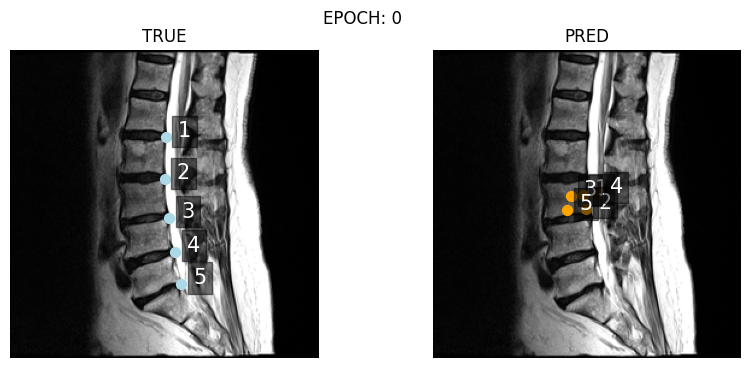

Epoch 1, Training Loss: 0.0, Validation Loss: 0.017067422425108298


100%|██████████| 14/14 [00:02<00:00,  6.77it/s]


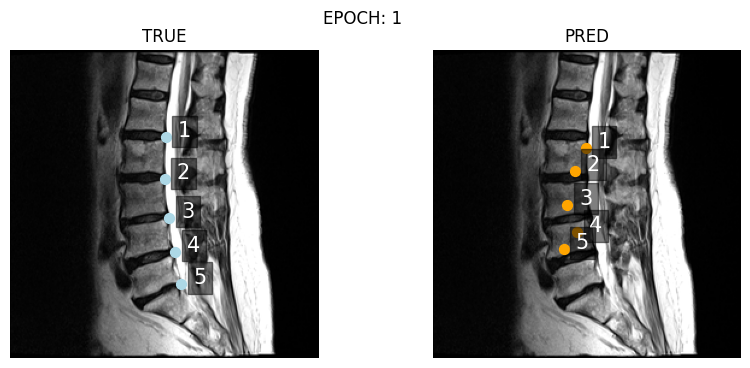

Epoch 2, Training Loss: 0.0018986258655786514, Validation Loss: 0.005231811531952449


100%|██████████| 14/14 [00:02<00:00,  6.40it/s]


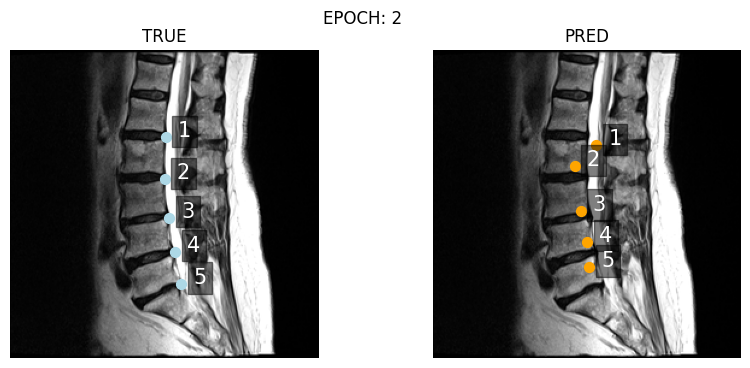

Epoch 3, Training Loss: 0.0009013921953737736, Validation Loss: 0.003590799992837544


100%|██████████| 14/14 [00:02<00:00,  6.46it/s]


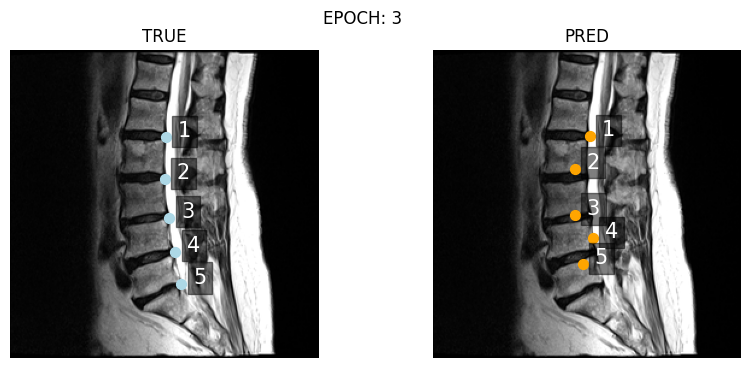

Epoch 4, Training Loss: 0.0009565997752361, Validation Loss: 0.003559906335015382


100%|██████████| 14/14 [00:02<00:00,  5.68it/s]


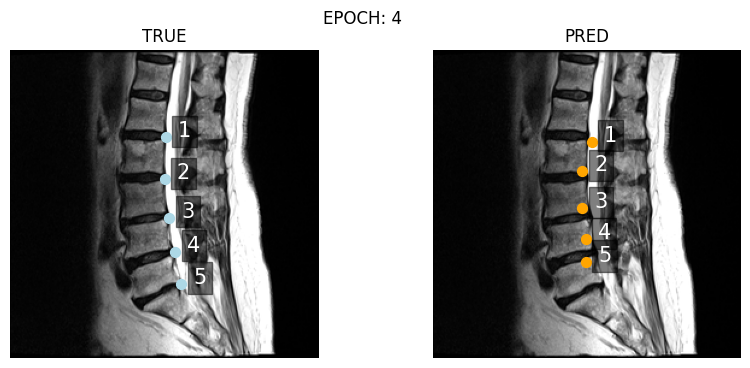

Epoch 5, Training Loss: 0.0006436245748773217, Validation Loss: 0.0029157940298318863


100%|██████████| 14/14 [00:02<00:00,  6.45it/s]


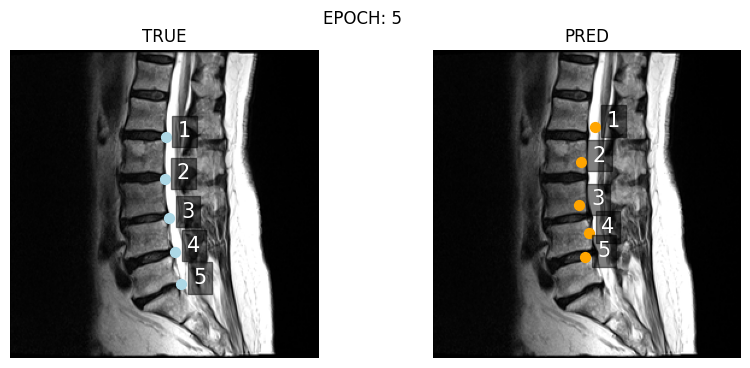

Epoch 6, Training Loss: 0.0005586033803410828, Validation Loss: 0.0032719985798134337
Training completed...


In [ ]:
for epoch in range(cfg.epochs + 1):



    # Training loop

    loss = torch.tensor([0.]).float().to(cfg.device)  # Initialize training loss as 0

    if epoch != 0:  # Skip training for epoch 0

        model = model.train()  # Set the model to training mode

        for batch in tqdm(train_dl):  # Iterate over batches in the training data loader

            batch = batch_to_device(batch, cfg.device)  # Move batch data to the specified device



            optimizer.zero_grad()  # Zero the gradients



            x_out = model(batch["img"].float())  # Forward pass to get model output

            x_out = torch.sigmoid(x_out)  # Apply the Sigmoid function to map output to [0, 1]



            loss = criterion(x_out, batch["label"].float())  # Compute the loss

            loss.backward()  # Backpropagate to compute gradients

            optimizer.step()  # Update model parameters



    # Validation loop

    val_loss = 0  # Initialize validation loss as 0

    with torch.no_grad():  # No gradient computation is needed during validation

        model = model.eval()  # Set the model to evaluation mode

        for batch in tqdm(val_dl):  # Iterate over batches in the validation data loader

            batch = batch_to_device(batch, cfg.device)  # Move batch data to the specified device



            pred = model(batch["img"].float())  # Forward pass to get model predictions

            pred = torch.sigmoid(pred)  # Apply the Sigmoid function to map predictions to [0, 1]



            val_loss += criterion(pred, batch["label"].float()).item()  # Compute and accumulate validation loss

        val_loss /= len(val_dl)  # Calculate average validation loss



    # Visualization

    visualize_prediction(batch, pred, epoch)  # Visualize the current batch predictions



    print(f"Epoch {epoch + 1}, Training Loss: {loss.item()}, Validation Loss: {val_loss}")

    # Print the current epoch's training loss and validation loss



print("Training completed...")

In [ ]:
f= "{}_{}.pt".format(cfg.backbone)

torch.save(model.state_dict(), f)

print("Saved weights: {}".format(f))